# Analisador de Fake News


///////////////// Introdução
//////////////// Sumário
# OLHAR ESSES LINKS****
- seguir esse https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a - ESSE DAQUI TEM O PRECISION/RECALL/ TRATAMENTO DOS DADOS DO INICIO AO FIM OLHAR ELE: https://stackabuse.com/text-classification-with-python-and-scikit-learn/



1. Importações
2. Leitura dos Dados
3. Limpeza e Transformações dos Dados
4. Redução de Dimensionalidade dos Dados
5. Visualizações dos dados
6. Avaliação dos Modelos
7. Conclusão

# 1. Importações

In [1]:
import numpy as np
import pandas as pd
import warnings
from statistics import mean
from math import log, pi, sqrt
import matplotlib.pyplot as plt
# Tratamento do Texto
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from scipy.linalg import svd 
from sklearn import linear_model, datasets, svm, metrics
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import DistanceMetric, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stop = stopwords.words('english')
warnings.filterwarnings("ignore")
np.random.seed(12345)

[nltk_data] Downloading package wordnet to /home/edvar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/edvar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/edvar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Leitura dos Dados

In [2]:
dataset = pd.read_csv("data/data.csv") # será utilizado para computar coisas nas visualizações
dataset['Body'] = dataset['Body'].astype(str) 
data = dataset # será limpado e utilizado nos modelos
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


# 3. Limpeza dos Dados

In [3]:
# Deixar tudo em lower case
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Body'] = data['Body'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
# Removendo pontuação
data['Headline'] = data['Headline'].str.replace('[^\w\s]','')
data['Body'] = data['Body'].str.replace('[^\w\s]','')
# Removendo stopwords
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in str(x).split() if str(x) not in stop))
# 10 Palavras mais frequentes e menos frequentes
freqHeadline = pd.Series(' '.join(data['Headline']).split()).value_counts()[:10]
freqBody = pd.Series(' '.join(data['Body']).split()).value_counts()[:10]
rareHead = pd.Series(' '.join(data['Headline']).split()).value_counts()[-10:]
rareBody = pd.Series(' '.join(data['Body']).split()).value_counts()[-10:]
# Remoção das palavras raras e frequentes
freqHeadline = list(freqHeadline.index)
freqBody = list(freqBody.index)
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in freqHeadline))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in freqBody))
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in rareHead))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in rareBody))
# Lemmatization. Extrai o núcleo/root da palavra
data['Headline'] = data['Headline'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['Body'] = data['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,four way bob corker skewered donald,image copyright getty image sunday morning don...,1
1,https://www.reuters.com/article/us-filmfestiva...,linklaters war veteran comedy speaks modern am...,london reuters last flag flying comedydrama vi...,1
2,https://www.nytimes.com/2017/10/09/us/politics...,trump fight corker jeopardizes legislative agenda,feud broke public view last week mr corker mr ...,1
3,https://www.reuters.com/article/us-mexico-oil-...,egypt cheiron win tieup pemex mexican onshore ...,mexico city reuters egypt cheiron holding limi...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,jason aldean open snl tribute,country singer jason aldean performing la vega...,1


In [4]:
vectorizer = CountVectorizer()
vectorizer.fit(data['Headline']) # tokenize and build vocabulary
vector = vectorizer.transform(data['Headline']) # encode document
print("Tamanho: ", vector.shape)
head = [key for key in  vectorizer.vocabulary_]
df = pd.DataFrame(vector.toarray(), columns = head)
df['Label'] = data['Label']
df.head()

Tamanho:  (4009, 6633)


,four,way,bob,corker,skewered,donald,linklaters,war,veteran,comedy,...,tragic,hervé,leroux,léger,bandage,dress,30minute,100000,antiamerican,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# 4. Redução da Dimensionalidade

In [5]:
from scipy.linalg import svd 

def fisher_score(x, y):
    mean = np.mean(x, axis=0)
    classes = np.unique(y)
    sS = 0
    sD = 0
    Nk = []
    
    meanD = []
    varD = []
    
    for k in classes:
        elements = []
        s = 0
        for i in range(0, len(y)):
            if(y[i] == k):
                s += 1
                elements.append(x[i])
        meanD.append(np.mean(elements, axis=0))
        varD.append(np.var(elements, axis=0))
        Nk.append(s)
    
    for k in range(0, len(classes)):
        sS += (Nk[k] * ((meanD[k] - mean)**2))
        sD += (Nk[k] * varD[k])
    return sS/sD


def compute(x):
    mean = np.mean(x, axis = 0)
    cov = np.cov(np.transpose(x))

    U, S, V = svd(cov)
    S = np.diag(S)
    M = U @ S @ V
    P = np.transpose(U)
    return {'S': S, 'U': U, 'V': V, 'M': M, 'P': P}

def transform(x, rateVariance):
    pca_result = compute(x)
    
    S = pca_result['S']
    P = pca_result['P']
    
 #   autovalores = np.sort([S[i][i] for i in range(len(S))])[::-1]
    #varianciaExplicadaTot = np.sum(np.array(autovalores))
    #varianceExpl = rateVarience*varianciaExplicadaTot

    #matrizTransform = []
    
    matrizTransform = []
    varianciaExplicadaTot = 0
    varianceExpl = 0
    autoValores = []
    for i in range(0, S.shape[0]):
        varianciaExplicadaTot += S[i,i]
        autoValores.append(S[i,i])
    varianceExpl = rateVariance *varianciaExplicadaTot

    autoValOrdenados = np.sort(autoValores)
    autoValOrdenados = autoValOrdenados[::-1]
    
    varianceAtual = 0
    i = 0
    while(varianceAtual<=varianceExpl and i<autoValOrdenados.shape[0]):
        for j in range (0, len(autoValores)):
            if(autoValOrdenados[i]==autoValores[j]):
                matrizTransform.append(P[j])
        varianceAtual += autoValOrdenados[i]
        i += 1
    return {'P': matrizTransform, 'Z':np.transpose(np.dot(matrizTransform, np.transpose(x)))}

In [6]:
resultPCA = transform(df.values[:,0:-1], 0.9)

In [7]:
dataPCA = np.hstack((resultPCA['Z'], df.values[:,-1][:,None]))
matrizPCA = resultPCA['P']

In [8]:
fisher_scores = fisher_score(dataPCA[:,0:-1], dataPCA[:,-1])
qnt = 1000 # quantas colunas quer dropar pelo fisher score
indices = [] # armazena os indices dos menores valores do fisher_score -> que é o que vamos dropar
for i in range(qnt): # faz o processamento de armazenar os indices dos menores valores
    indice = np.argmin(fisher_scores)
    fisher_scores[indice] = 10000
    indices.append(indice)

dataPCA = pd.DataFrame(dataPCA)
data_fisher = dataPCA.drop([dataPCA.columns[i] for i in indices] ,  axis='columns')
data_fisher.head()
#classes, ocorrencs = np.unique(indices, return_counts=True)
#dict(zip(classes, ocorrencs))

,0,1,2,3,4,5,6,9,10,11,...,1384,1385,1391,1392,1393,1396,1408,1416,1442,1443
0,0.025691,-0.024908,-0.033536,-0.035617,-0.019979,0.013174,-0.043956,0.347828,0.115814,0.209173,...,0.010046,-0.026671,0.016280,-0.008756,0.009904,-0.004972,-0.022256,-0.018021,0.006211,1.0
1,-0.027006,-0.010446,-0.018248,0.002828,-0.020727,0.010261,-0.005490,0.087275,0.024959,-0.015825,...,0.023019,0.030738,0.058222,0.035099,-0.026443,0.007620,0.039160,0.075989,-0.003723,1.0
2,-0.030486,-0.036349,-0.050328,0.012328,-0.020410,-0.060556,-0.003561,0.513493,0.173937,0.247639,...,-0.079340,0.027955,-0.018294,-0.008573,-0.064756,0.063006,-0.023390,0.003520,-0.007349,1.0
3,0.748007,0.052071,0.001556,0.219500,-0.554973,-0.049230,0.136265,-0.171266,0.225036,0.103063,...,0.070942,-0.021779,0.044220,-0.012639,0.035847,0.009095,0.021145,0.043907,-0.012496,1.0
4,-0.017514,-0.019153,-0.030974,0.002869,-0.009001,-0.039643,0.032424,-0.058940,0.003085,-0.023764,...,0.000223,-0.004052,0.000320,0.009841,0.002921,0.027044,-0.005193,0.005098,-0.012084,1.0


# 5. Visualização e Análise dos dados

- https://www.mien.in/2017/10/02/visual-text-analytics-with-python/
- visualizações ta tudo aqui: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
- o coisa la do kaggle https://www.kaggle.com/kumudchauhan/fake-news-analysis-and-classification#506957

0. dataset.describe()
0. dataset.corr()

0. WordCloud

1. Palavras mais frequentes por classe - sem stopwords - (grafico de barras)
2. Palavras menos frequentes por classe - sem stopwords - (grafico de barras)

3. Relação de stopwords em noticias reais/Fakes
4. Relação da Escrita errada/correta em noticias reais/Fakes

5. The distribution of top bigrams before removing stop words
6. Analise de Sentimentos

Which sources publish real news
Which sources publish maximum fake news?
3 Is there any common source which reports both real and fake news?
 Do sources include movies in the news to get more attention?
 Do sources include images in all the news as images provides visual cues?
 Most discriminatory words in the title of news
 Density distribuiton of title length for real and fake news


Lexical dispersion plot
Frequency distribution plot:
Lexical diversity dispersion plot
N-gram frequency distribution plot:
Top 20 bigrams in review after removing stop words
The distribution of Top trigrams before removing stop words
The distribution of Top trigrams after removing stop words

In [9]:
# https://pythondata.com/text-analytics-visualization/
# https://doc.lagout.org/Others/Data%20Mining/Text%20Mining%20and%20Visualization_%20Case%20Studies%20using%20Open-Source%20Tools%20%5BHofmann%20%26%20Chisholm%202015-12-18%5D.pdf
# https://itnext.io/basics-of-text-analysis-visualization-1978de48af47
# https://kanoki.org/2019/03/17/text-data-visualization-in-python/
# https://realpython.com/python-keras-text-classification/ (LER ISSO AQUI SEM DELONGAS)
# https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/ (LER ISSO AQUI)
# https://towardsdatascience.com/text-classification-in-python-dd95d264c802 (LER ISSO AQUI)
#
#

In [10]:



#usar dataset pós-limpeza
dataset = data

In [11]:
titulosFake = ""
titulosReal = ""
for i in range(0, dataset.shape[0]):
    if (dataset['Label'][i]==1):
        titulosFake += dataset['Headline'][i]+" "
    else:
        titulosReal += dataset['Headline'][i]+" "

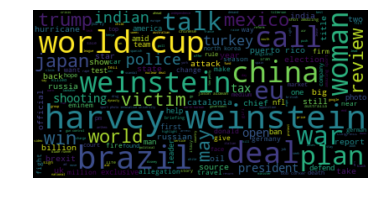

In [12]:
wordcloud = WordCloud(max_font_size=100).generate(titulosFake)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

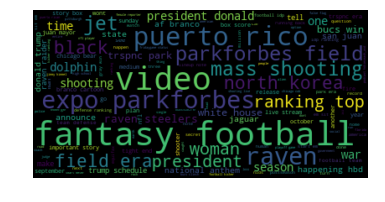

In [13]:
wordcloud = WordCloud(max_font_size=100).generate(titulosReal)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [14]:
wordsFake = titulosFake.split()
wordsReal = titulosReal.split()

In [15]:
distinctFake = []
distinctReal = []
for i in wordsFake:
    if i not in distinctFake:
        distinctFake.append(i)
for i in wordsReal:
    if i not in distinctReal:
        distinctReal.append(i)

In [16]:
countFake = []
countReal = []
for i in distinctFake:
    cont = 0
    for j in wordsFake:
        if (i==j):
            cont += 1
    countFake.append(cont)
for i in distinctReal:
    cont = 0
    for j in wordsReal:
        if (i==j):
            cont += 1
    countReal.append(cont)

In [17]:
from operator import itemgetter

dictFake = {}
for i in range(0, len(distinctFake)):
    dictFake[distinctFake[i]] =  countFake[i]
    
dictFake = sorted(dictFake.items(), key=itemgetter(1), reverse=True)

dictReal = {}
for i in range(0, len(distinctReal)):
    dictReal[distinctReal[i]] =  countReal[i]

dictReal = sorted(dictReal.items(), key=itemgetter(1), reverse=True)

wordsFake = []
wordsReal = []
contFake = []
contReal = []
for i in range(0, 15):
    wordsFake.append(dictFake[i][0])
    contFake.append(dictFake[i][1])
    wordsReal.append(dictReal[i][0])
    contReal.append(dictReal[i][1])

<BarContainer object of 15 artists>

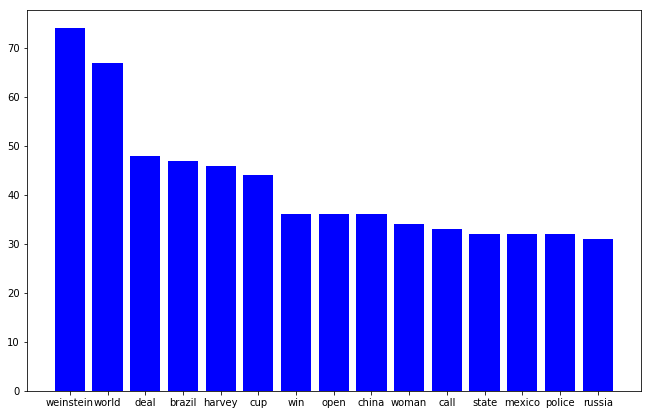

In [18]:
plt.rcParams['figure.figsize'] = (11,7)
plt.bar(wordsFake, contFake, color="blue")

<BarContainer object of 15 artists>

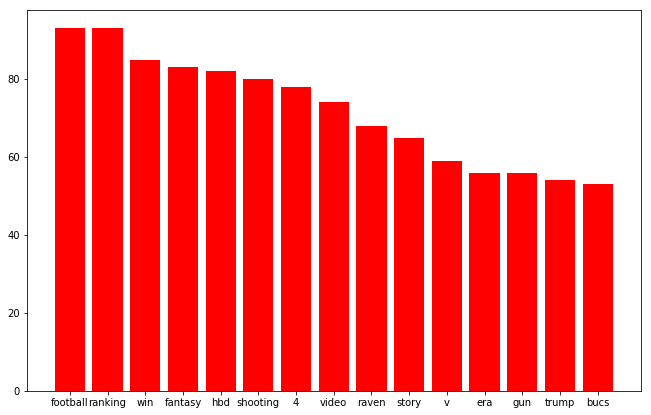

In [19]:
plt.bar(wordsReal, contReal, color="red")

# 6. Avaliação de Métodos

In [20]:
# Split dos Dados
# atribuindo X com as features e y com os valores de classe
X = data_fisher.values[:,:-1]
Y = data_fisher.values[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [21]:
from modelos import distance_euclidian, distance_manhattan, fitAD, fitAGD, fitRF, fitRL, fitSVM, getClasses, predict1AGD, predict1KNN, predictAD, predictAGD, predictKNN, predictRF, predictRL, predictSVM, sigmoide 

In [22]:
def acc(y_test, results):
    tot = [1 for x,z in zip(y_test,results) if x == z]
    return (np.sum(np.array(tot))/len(y_test))*100

## 6.1. Regressão Logística

In [23]:
acc(y_test, predictRL(fitRL(x_train, y_train, 1000, 0.001)[0], x_test))

52.74177467597209

## 6.2. KNN

In [24]:
acc(y_test, predictKNN(x_train, y_train, x_test, 5, distance_euclidian))

62.412761714855435

## 6.3. Análise Discriminante Gaussiano

In [25]:
acc(y_test, predictAGD(fitAGD(x_train, y_train), x_test))

ZeroDivisionError: float division by zero

## 6.4. Árvore de Decisão

In [26]:
acc(y_test, predictAD(fitAD(x_train, y_train), x_train, y_train, x_test))

77.16849451645065

## 6.5. SVM

In [27]:
acc(y_test, predictSVM(fitSVM(x_train, y_train), x_train, y_train, x_test))

KeyboardInterrupt: 

## 6.6. Random Forest

In [ ]:
acc(y_test, predictRF(fitRF(x_train, y_train), x_train, y_train, x_test))